In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
class LargeModel(nn.Module):
    def __init__(self):
        super(LargeModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, 10)
        self.dropout = nn.Dropout2d(0.5)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.fc3(x)
        return out

class DistilModel(nn.Module):
    def __init__(self):
        super(DistilModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 800)
        self.fc2 = nn.Linear(800, 800)
        self.fc3 = nn.Linear(800, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out


In [11]:
def train_large(model, train_loader, optimizer, epochs, device):
    model.train()
    loss_arr = []

    for e in range(epochs):
        epoch_loss = 0
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        loss_arr.append(epoch_loss)
        print(f'Epoch {e+1}/{epochs}, Loss: {epoch_loss:.4f}')

    plt.plot(loss_arr)
    plt.title('Training Loss - Large Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def train_distil(large_model, distil_model, train_loader, optimizer, loss_fn, device, epochs=10, temp=20, distil_weight=0.7):
    large_model.eval()
    distil_model.train()
    loss_arr = []

    for e in range(epochs):
        epoch_loss = 0
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                soft_label = F.softmax(large_model(data) / temp, dim=1)

            out = distil_model(data)
            soft_out = F.softmax(out / temp, dim=1)

            loss = (1 - distil_weight) * F.cross_entropy(out, label) + distil_weight * loss_fn(soft_out, soft_label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        loss_arr.append(epoch_loss)
        print(f'Epoch {e+1}/{epochs}, Loss: {epoch_loss:.4f}')

    plt.plot(loss_arr)
    plt.title('Training Loss - Distil Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [4]:
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = len(data_loader.dataset)

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f} ({correct}/{total})')
    return accuracy

Training Large Model...
Epoch 1/20, Loss: 237.7750
Epoch 2/20, Loss: 95.9459
Epoch 3/20, Loss: 70.9531
Epoch 4/20, Loss: 56.0603
Epoch 5/20, Loss: 47.2176
Epoch 6/20, Loss: 41.7125
Epoch 7/20, Loss: 35.0999
Epoch 8/20, Loss: 32.0292
Epoch 9/20, Loss: 28.0985
Epoch 10/20, Loss: 26.3362
Epoch 11/20, Loss: 23.2467
Epoch 12/20, Loss: 20.7724
Epoch 13/20, Loss: 19.7880
Epoch 14/20, Loss: 18.7296
Epoch 15/20, Loss: 16.8140
Epoch 16/20, Loss: 15.3899
Epoch 17/20, Loss: 13.8318
Epoch 18/20, Loss: 13.5256
Epoch 19/20, Loss: 12.9196
Epoch 20/20, Loss: 11.7194


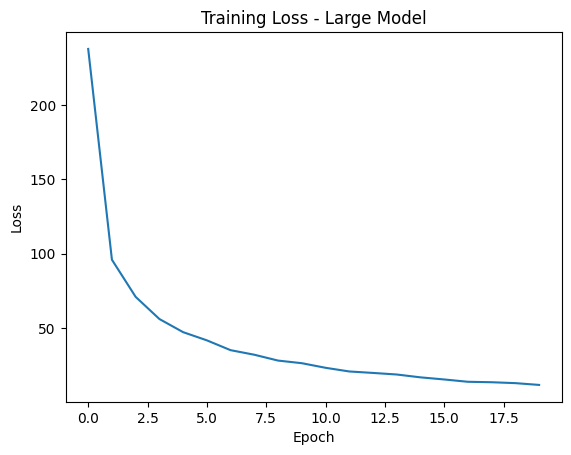

Evaluating Large Model...
Accuracy: 0.9843 (9843/10000)
Training Distil Model...
Epoch 1/20, Loss: 98.8256
Epoch 2/20, Loss: 40.7568
Epoch 3/20, Loss: 30.3450
Epoch 4/20, Loss: 23.9033
Epoch 5/20, Loss: 19.6053
Epoch 6/20, Loss: 16.5011
Epoch 7/20, Loss: 14.0091
Epoch 8/20, Loss: 11.9761
Epoch 9/20, Loss: 10.3565
Epoch 10/20, Loss: 9.0544
Epoch 11/20, Loss: 7.9416
Epoch 12/20, Loss: 6.9615
Epoch 13/20, Loss: 6.1393
Epoch 14/20, Loss: 5.3630
Epoch 15/20, Loss: 4.7338
Epoch 16/20, Loss: 4.1779
Epoch 17/20, Loss: 3.6282
Epoch 18/20, Loss: 3.2432
Epoch 19/20, Loss: 2.9173
Epoch 20/20, Loss: 2.5106


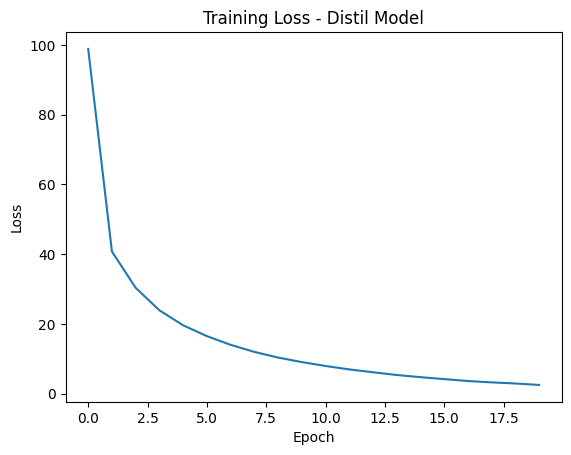

Evaluating Distil Model...
Accuracy: 0.9805 (9805/10000)


In [12]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    batch_size = 100

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

    large_model = LargeModel().to(device)
    optimizer_large = optim.SGD(large_model.parameters(), lr=0.01, momentum=0.9)
    epochs = 20

    print("Training Large Model...")
    train_large(large_model, train_loader, optimizer_large, epochs, device)
    print("Evaluating Large Model...")
    evaluate(large_model, test_loader, device)

    distil_model = DistilModel().to(device)
    optimizer_distil = optim.SGD(distil_model.parameters(), lr=0.01, momentum=0.9)
    loss_fn = nn.MSELoss()

    print("Training Distil Model...")
    train_distil(
        large_model=large_model,
        distil_model=distil_model,
        train_loader=train_loader,
        optimizer=optimizer_distil,
        loss_fn=loss_fn,
        device=device,
        epochs=epochs,        # Here 'epochs' is specified as a keyword argument
        temp=20,              # Specify 'temp' as a keyword argument
        distil_weight=0.7     # Specify 'distil_weight' as a keyword argument
    )
    print("Evaluating Distil Model...")
    evaluate(distil_model, test_loader, device)

if __name__ == '__main__':
    main()
